In [1]:
import keras
import keras.applications.mobilenet_v2 as k_mobilenet_v2
import keras.backend as k
import keras.datasets.mnist as k_mnist
import keras.layers as k_layers
from keras.layers import Dense
import keras.losses as k_losses
import keras.models as k_models
import keras.optimizers as k_optimizers
import keras.preprocessing.image as k_image
import keras.utils as k_utils
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from math import ceil

Using TensorFlow backend.


## Funkcja wizualizujaca wygenerowana heatmape

In [2]:
def visualize_heatmap(heatmap, image):
    fig, axs = plt.subplots(1, 3, figsize=(16, 3.8))
    
    axs[0].imshow(image)
    axs[0].axis('off')

    axs[1].imshow(image)
    axs[1].axis('off')
    cmap_img = axs[1].matshow(heatmap, cmap='jet', alpha=0.6)
    plt.colorbar(cmap_img)
    
    cmap_img = axs[2].matshow(heatmap, cmap='jet')
    axs[2].axis('off')
    plt.axis('off')
    
    plt.show()

## Funkcja generujaca heatmape

In [3]:
def generate_heatmap(model, preprocessed_image, rectangle_width = 40, rectangle_height = 40, horizontal_move = 10, vertical_move = 10):
    if(vertical_move > rectangle_height):
        print("Vertical move cant be bigger than rectangle height")
        return
    
    if(horizontal_move > rectangle_width):
        print("Horizontal move cant be bigger than rectangle width")
        return
    
    # stworzenia kontenera na heatmape
    heatmap_shape = (preprocessed_image.shape[1], preprocessed_image.shape[2], 2)
    heatmap = np.zeros(heatmap_shape)
    
    # wykonanie podstawowej predykcji
    base_image_predictions = model.predict(preprocessed_image)
    image_class = np.argmax(base_image_predictions[0])
    image_class_probability = base_image_predictions[0, image_class]
    print("Picture prodictions", k_mobilenet_v2.decode_predictions(base_image_predictions, top=5)[0])
    
    for row in range(ceil(heatmap_shape[0] / vertical_move)):
        for column in range(ceil(heatmap_shape[1] / horizontal_move)):
        
            # zasloniecie fragmentu obrazka
            image = preprocessed_image.copy()
            image[0, 
                  row * vertical_move: min(row * vertical_move + rectangle_height, heatmap_shape[0]), 
                  column * horizontal_move: min(column * horizontal_move + rectangle_width, heatmap_shape[1])] = [0.8, 0.8, 0.8]
            # plt.imshow(image[0])
            # plt.show()
            
            # predykcja na zaslonietym obrazku
            new_image_predictions = model.predict(image)
            new_image_class_probability = new_image_predictions[0][image_class]

            # aktualizacja predykcji dla kazdego piksela
            for x in range(row * vertical_move, min(row * vertical_move + rectangle_height, heatmap_shape[0])):
                for y in range(column * horizontal_move, min(column * horizontal_move + rectangle_width, heatmap_shape[1])):
                    if heatmap[x, y, 1] == 0:
                        heatmap[x, y] = [new_image_class_probability, 1]
                    else:
                        heatmap[x, y] = [heatmap[x, y, 0] + new_image_class_probability, heatmap[x, y, 1] + 1]

    # usrednienie predykcji dla kazdego piksela
    mean_heatmap = np.zeros(heatmap_shape[:-1])
    mean_heatmap[0:heatmap_shape[0], 0:heatmap_shape[1]] = \
        heatmap[0:heatmap_shape[0], 0:heatmap_shape[1], 0] / \
        heatmap[0:heatmap_shape[0], 0:heatmap_shape[1], 1]
    
    return mean_heatmap

## Wczytanie modelu

In [4]:
model = k_mobilenet_v2.MobileNetV2(weights='imagenet', include_top=True)

Instructions for updating:
Colocations handled automatically by placer.


## Wczytanie i preprocessing obrazka

In [5]:
image_path = './pictures/ogorek.jpg'
image = k_image.load_img(image_path, target_size=(224, 224))
preprocessed_image = k_image.img_to_array(image)  
preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
preprocessed_image = k_mobilenet_v2.preprocess_input(preprocessed_image)

## Wizualizacja obrazka i wygenerowanej heatmapy

Picture prodictions [('n07718472', 'cucumber', 0.8410487), ('n01930112', 'nematode', 0.06505076), ('n07716358', 'zucchini', 0.01912582), ('n01945685', 'slug', 0.009167698), ('n02264363', 'lacewing', 0.0038036488)]


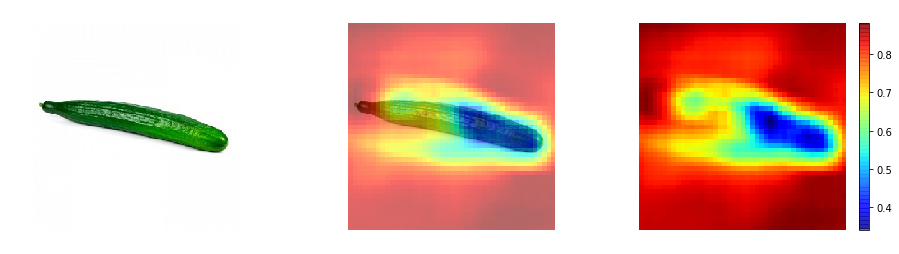

In [6]:
visualize_heatmap(
    generate_heatmap(
        model, 
        preprocessed_image, 
        rectangle_height=30, 
        rectangle_width=30, 
        vertical_move=5,
        horizontal_move=5,
    ),
    image
)

## Kolejna przykladowa wizualizacja

Picture prodictions [('n04153751', 'screw', 0.93682486), ('n03804744', 'nail', 0.008936935), ('n03109150', 'corkscrew', 0.0032088193), ('n03065424', 'coil', 0.0024414016), ('n03532672', 'hook', 0.0023474018)]


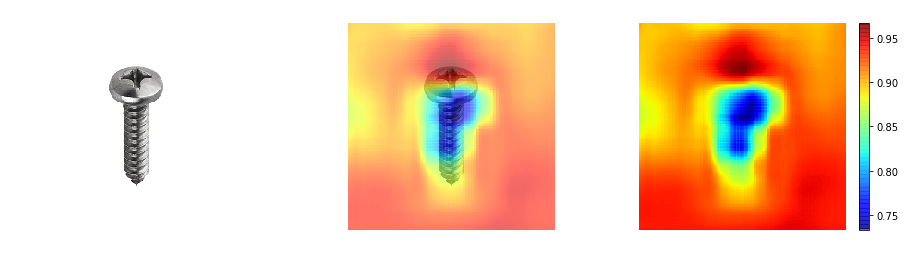

In [7]:
image_path = './pictures/screw.jpg'
image = k_image.load_img(image_path, target_size=(224, 224))
preprocessed_image = k_image.img_to_array(image)  
preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
preprocessed_image = k_mobilenet_v2.preprocess_input(preprocessed_image)

visualize_heatmap(
    generate_heatmap(
        model, 
        preprocessed_image, 
        rectangle_height=40, 
        rectangle_width=40, 
        vertical_move=3,
        horizontal_move=3,
    ),
    image
)